# Predicting Optimal Ski Conditions and Season Length in Lake Tahoe

## Introduction

This notebook explores how machine learning models can predict optimal ski conditions and season length for Lake Tahoe ski resorts through analysis of historical weather patterns and climate indicators.

### Research Question

How can machine learning models predict optimal ski conditions and season length for Lake Tahoe ski resorts by analyzing historical weather patterns and climate indicators?

### Data Sources

This analysis uses three primary datasets:
1. **NOAA Weather Station Data**: Daily observations from multiple stations around Lake Tahoe (2014-2025)
2. **Resort Season Records**: Historical opening and closing dates for four major Tahoe resorts (Heavenly, Palisades, Sugar Bowl, and Kirkwood)
3. **NOAA Oceanic Niño Index (ONI)**: El Niño/La Niña climate pattern measurements that influence Western US weather

### Notebook Overview

This notebook (Part 1 of 2) covers:
1. Data processing and cleaning
2. Feature engineering to capture weather patterns
3. Exploratory data analysis to understand key relationships
4. Integration of weather and climate metrics

The subsequent notebook will focus on model development, evaluation, and interpretation.

## Setup and Data Loading

First, we'll import the necessary libraries for data manipulation, visualization, and analysis. These libraries will help us process weather data, transform temporal features, and visualize patterns.

Key libraries include:
- **pandas & numpy**: For data manipulation and numerical operations
- **matplotlib & seaborn**: For data visualization
- **datetime**: For handling date-based calculations

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visualization style for consistent, professional plots
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("colorblind")  # Accessibility-friendly color scheme

# Define standard figure size for consistent visualizations
plt_figsize = (12, 8)

# Set display options for better dataframe viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Loading and processing datasets...")

# Load the three primary datasets
weather_df = pd.read_csv('Tahoe_NOAA_Data.csv')
resort_df = pd.read_csv('Tahoe_Resort_Season_Dates.csv')
oni_df = pd.read_csv('NOAA_ONI_Data.csv')

print("Datasets loaded successfully.")

Loading and processing datasets...
Datasets loaded successfully.


## Data Overview

Before processing, let's examine each dataset to understand its structure and content.

### Weather Station Data

The weather data comes from NOAA stations located around Lake Tahoe. Each row represents weather observations for a specific station on a specific date, including:
- Temperature measurements (max, min, average)
- Precipitation amounts
- Snowfall and snow depth measurements
- Station metadata (elevation, location)

In [8]:
# Display basic information about the weather dataset
print("Weather Dataset Shape:", weather_df.shape)
print("\nWeather Dataset Columns:")
print(weather_df.columns.tolist())

# Display the first few rows of weather data
print("\nSample Weather Data:")
display(weather_df.head())

# Display summary statistics for key weather variables
print("\nWeather Measurement Statistics:")
weather_stats = weather_df[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']].describe()
display(weather_stats)

# Display unique weather stations and their elevations
unique_stations = weather_df[['STATION', 'NAME', 'ELEVATION']].drop_duplicates()
print("\nWeather Stations in Dataset:")
display(unique_stations)

# Check for missing values in key weather variables
missing_weather = weather_df[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']].isnull().sum()
print("\nMissing Values in Weather Variables:")
display(missing_weather)

Weather Dataset Shape: (28295, 58)

Weather Dataset Columns:
['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'AWND', 'AWND_ATTRIBUTES', 'DAPR', 'DAPR_ATTRIBUTES', 'MDPR', 'MDPR_ATTRIBUTES', 'PGTM', 'PGTM_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES', 'SNOW', 'SNOW_ATTRIBUTES', 'SNWD', 'SNWD_ATTRIBUTES', 'TAVG', 'TAVG_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES', 'TMIN', 'TMIN_ATTRIBUTES', 'TOBS', 'TOBS_ATTRIBUTES', 'WDF2', 'WDF2_ATTRIBUTES', 'WDF5', 'WDF5_ATTRIBUTES', 'WDMV', 'WDMV_ATTRIBUTES', 'WESD', 'WESD_ATTRIBUTES', 'WESF', 'WESF_ATTRIBUTES', 'WSF2', 'WSF2_ATTRIBUTES', 'WSF5', 'WSF5_ATTRIBUTES', 'WT01', 'WT01_ATTRIBUTES', 'WT02', 'WT02_ATTRIBUTES', 'WT03', 'WT03_ATTRIBUTES', 'WT04', 'WT04_ATTRIBUTES', 'WT05', 'WT05_ATTRIBUTES', 'WT06', 'WT06_ATTRIBUTES', 'WT08', 'WT08_ATTRIBUTES', 'WT11', 'WT11_ATTRIBUTES']

Sample Weather Data:


,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,DAPR,DAPR_ATTRIBUTES,MDPR,MDPR_ATTRIBUTES,PGTM,PGTM_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WDF2,WDF2_ATTRIBUTES,WDF5,WDF5_ATTRIBUTES,WDMV,WDMV_ATTRIBUTES,WESD,WESD_ATTRIBUTES,WESF,WESF_ATTRIBUTES,WSF2,WSF2_ATTRIBUTES,WSF5,WSF5_ATTRIBUTES,WT01,WT01_ATTRIBUTES,WT02,WT02_ATTRIBUTES,WT03,WT03_ATTRIBUTES,WT04,WT04_ATTRIBUTES,WT05,WT05_ATTRIBUTES,WT06,WT06_ATTRIBUTES,WT08,WT08_ATTRIBUTES,WT11,WT11_ATTRIBUTES
0,USC00048758,"TAHOE CITY, CA US",39.1678,-120.1428,1898.9,2014-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,",,7,0800",0.0,",,7,",1.0,",,7,",NaN,NaN,49.0,",,7",22.0,",,7",23.0,",,7,0800",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00048758,"TAHOE CITY, CA US",39.1678,-120.1428,1898.9,2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,",,7,0800",0.0,",,7,",1.0,",,7,",NaN,NaN,47.0,",,7",22.0,",,7",26.0,",,7,0800",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00048758,"TAHOE CITY, CA US",39.1678,-120.1428,1898.9,2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,",,7,0800",0.0,",,7,",1.0,",,7,",NaN,NaN,46.0,",,7",24.0,",,7",27.0,",,7,0800",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00048758,"TAHOE CITY, CA US",39.1678,-120.1428,1898.9,2014-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,",,7,0800",0.0,",,7,",1.0,",,7,",NaN,NaN,47.0,",,7",23.0,",,7",25.0,",,7,0800",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00048758,"TAHOE CITY, CA US",39.1678,-120.1428,1898.9,2014-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,",,7,0800",0.0,",,7,",1.0,",,7,",NaN,NaN,45.0,",,7",20.0,",,7",22.0,",,7,0800",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Weather Measurement Statistics:


,PRCP,SNOW,SNWD,TMAX,TMIN
count,28077.000000,24199.000000,24148.000000,27654.000000,27290.000000
mean,0.074540,0.385987,5.313794,58.449266,30.769586
std,0.288228,1.954692,13.507174,17.498792,12.289694
min,0.000000,0.000000,0.000000,12.000000,-20.000000
25%,0.000000,0.000000,0.000000,44.000000,23.000000
50%,0.000000,0.000000,0.000000,57.000000,30.000000
75%,0.000000,0.000000,2.000000,74.000000,40.000000
max,6.280000,46.000000,118.000000,99.000000,73.000000



Weather Stations in Dataset:


,STATION,NAME,ELEVATION
0,USC00048758,"TAHOE CITY, CA US",1898.9
4120,USW00093230,"SOUTH LAKE TAHOE AIRPORT, CA US",1907.0
8237,USC00040931,"BOCA, CA US",1699.3
12355,USC00049040,"TRUCKEE TAHOE AIRPORT, CA US",1798.3
16411,USC00263960,"INCLINE VILLAGE, NV US",1937.3
20182,USC00048760,"TAHOMA, CA US",1924.8
24303,USC00262119,"DAGGET PASS, NV US",2235.4



Missing Values in Weather Variables:


PRCP     218
SNOW    4096
SNWD    4147
TMAX     641
TMIN    1005
dtype: int64

### Ski Resort Season Data

The resort dataset contains historical opening and closing dates for four major Lake Tahoe ski resorts. This data will serve as our target variable - we aim to predict season length based on weather and climate indicators.

### Oceanic Niño Index (ONI) Data

The ONI dataset provides climate oscillation measurements that can significantly impact Western US winter weather patterns. El Niño (warm) and La Niña (cool) phases influence precipitation patterns in the Sierra Nevada mountains and are potentially valuable predictors for ski season characteristics.

In [11]:
# Display resort data overview
print("Resort Dataset Shape:", resort_df.shape)
print("\nResort Dataset Columns:")
print(resort_df.columns.tolist())

# Display sample resort data
print("\nSample Resort Season Data:")
display(resort_df.head())

# Display ONI data overview
print("\nONI Dataset Shape:", oni_df.shape)
print("\nONI Dataset Sample (El Niño/La Niña Measurements):")
display(oni_df.head())

# Check unique resorts in the dataset
print("\nUnique Resorts in Dataset:")
print(resort_df['Resort'].unique())

# Check date range of the datasets
print("\nWeather Data Date Range:")
print(f"From: {pd.to_datetime(weather_df['DATE']).min()}")
print(f"To: {pd.to_datetime(weather_df['DATE']).max()}")

print("\nResort Seasons Date Range:")
print(f"Earliest Season: {resort_df['Season'].min()}")
print(f"Latest Season: {resort_df['Season'].max()}")

Resort Dataset Shape: (44, 4)

Resort Dataset Columns:
['Resort', 'Season', 'OPENING DATE', 'CLOSING DATE']

Sample Resort Season Data:


,Resort,Season,OPENING DATE,CLOSING DATE
0,Heavenly,2014/2015,11/21/14,4/19/15
1,Heavenly,2015/2016,11/21/15,4/24/16
2,Heavenly,2016/2017,11/23/16,4/30/17
3,Heavenly,2017/2018,11/17/17,4/22/18
4,Heavenly,2018/2019,11/16/18,5/27/19



ONI Dataset Shape: (12, 13)

ONI Dataset Sample (El Niño/La Niña Measurements):


,Year,DJF,JFM,FMA,MAM,AMJ,MJJ,JJA,JAS,ASO,SON,OND,NDJ
0,2014,-0.4,-0.5,-0.3,0.0,0.2,0.2,0.0,0.1,0.2,0.5,0.6,0.7
1,2015,0.5,0.5,0.5,0.7,0.9,1.2,1.5,1.9,2.2,2.4,2.6,2.6
2,2016,2.5,2.1,1.6,0.9,0.4,-0.1,-0.4,-0.5,-0.6,-0.7,-0.7,-0.6
3,2017,-0.3,-0.2,0.1,0.2,0.3,0.3,0.1,-0.1,-0.4,-0.7,-0.8,-1.0
4,2018,-0.9,-0.9,-0.7,-0.5,-0.2,0.0,0.1,0.2,0.5,0.8,0.9,0.8



Unique Resorts in Dataset:
['Heavenly' 'Palisades' 'Sugar Bowl' 'Kirkwood']

Weather Data Date Range:
From: 2014-01-01 00:00:00
To: 2025-04-13 00:00:00

Resort Seasons Date Range:
Earliest Season: 2014/2015
Latest Season: 2024/2025


## Data Processing

To prepare our data for analysis and modeling, we need to transform raw measurements into meaningful features. This section focuses on:

1. **Date transformations**: Converting date strings to datetime objects and extracting useful components
2. **Season definition**: Creating consistent season identifiers across datasets
3. **Winter day calculation**: Defining a consistent metric for winter progression
4. **Missing value handling**: Ensuring complete data for analysis

Each dataset requires specific processing to align timestamps and create a unified analytical framework.

Processing weather data...

Sample of processed weather data:


,DATE,STATION,PRCP,SNOW,TMAX,TMIN,YEAR,MONTH,DAY,SEASON,WINTER_DAY
0,2014-01-01,USC00048758,0.0,0.0,49.0,22.0,2014,1,1,2013-2014,62
1,2014-01-02,USC00048758,0.0,0.0,47.0,22.0,2014,1,2,2013-2014,63
2,2014-01-03,USC00048758,0.0,0.0,46.0,24.0,2014,1,3,2013-2014,64
3,2014-01-04,USC00048758,0.0,0.0,47.0,23.0,2014,1,4,2013-2014,65
4,2014-01-05,USC00048758,0.0,0.0,45.0,20.0,2014,1,5,2013-2014,66



Weather station elevation statistics:


,ELEVATION
count,7.000000
mean,1914.428571
std,165.184641
min,1699.300000
25%,1848.600000
50%,1907.000000
75%,1931.050000
max,2235.400000


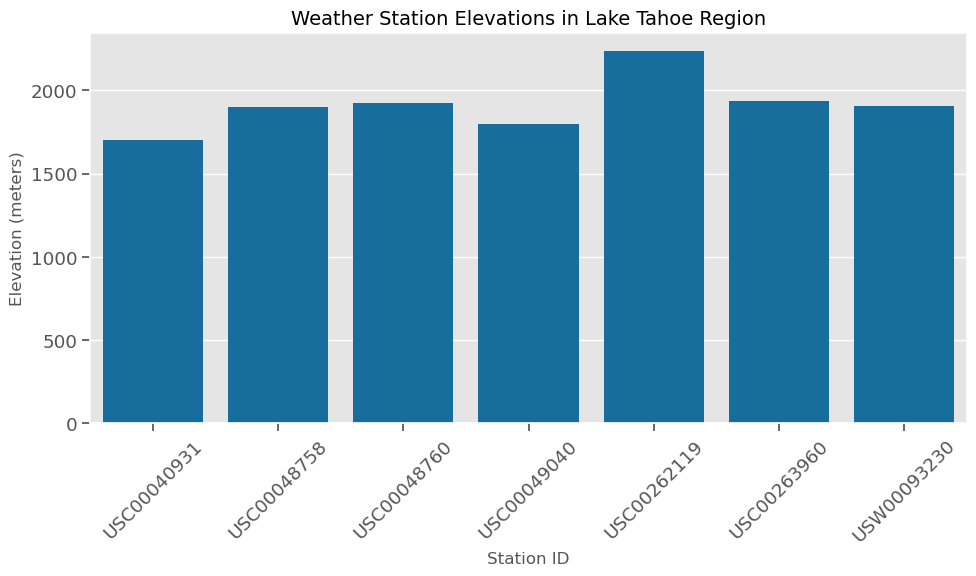

In [14]:
def process_weather_data(df):
    """
    Process raw weather data for analysis.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Raw weather data
        
    Returns:
    --------
    pandas.DataFrame
        Processed weather data with additional features
    """
    print("Processing weather data...")
    
    # Convert date to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])
    
    # Extract date components
    df['YEAR'] = df['DATE'].dt.year
    df['MONTH'] = df['DATE'].dt.month
    df['DAY'] = df['DATE'].dt.day
    df['DOY'] = df['DATE'].dt.dayofyear  # Day of year
    
    # Define winter season (July 1 to June 30)
    df['SEASON'] = df['DATE'].apply(
        lambda x: f"{x.year}-{x.year+1}" if x.month >= 7 else f"{x.year-1}-{x.year}"
    )
    
    # Define winter day (days since November 1)
    def winter_day(date):
        """Calculate days since November 1 of the season."""
        year = date.year
        nov1 = datetime(year, 11, 1)
        if date.month < 11:
            nov1 = datetime(year-1, 11, 1)
        return (date - nov1).days + 1
    
    df['WINTER_DAY'] = df['DATE'].apply(winter_day)
    
    return df

# Process weather data
weather_df = process_weather_data(weather_df)

# Display a sample of processed weather data
print("\nSample of processed weather data:")
display(weather_df[['DATE', 'STATION', 'PRCP', 'SNOW', 'TMAX', 'TMIN', 
                   'YEAR', 'MONTH', 'DAY', 'SEASON', 'WINTER_DAY']].head())

# Calculate station elevation statistics
print("\nWeather station elevation statistics:")
elevation_stats = weather_df.groupby(['STATION', 'NAME'])['ELEVATION'].first().reset_index()
display(elevation_stats.describe())

# Visualize station elevations
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='STATION', y='ELEVATION', data=elevation_stats)
ax.set_title('Weather Station Elevations in Lake Tahoe Region', fontsize=14)
ax.set_xlabel('Station ID', fontsize=12)
ax.set_ylabel('Elevation (meters)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Ski Resort Data Processing

The ski resort dataset contains opening and closing dates for each resort by season. We'll transform these dates into:

1. **Season length**: Total operating days for the season
2. **Opening/closing day of year**: Standardized metrics for comparing season timing
3. **Ski season identifier**: Consistent format matching our weather data seasons

This processed data will serve as our target values for prediction.

In [17]:
def process_resort_data(df):
    """
    Process resort opening/closing dates data.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Raw resort data
        
    Returns:
    --------
    pandas.DataFrame
        Processed resort data with calculated metrics
    """
    print("Processing resort data...")
    
    # Make a copy to avoid modifying the original
    processed_df = df.copy()
    
    # Convert dates to datetime
    processed_df['OPENING_DATE'] = pd.to_datetime(processed_df['OPENING DATE'])
    processed_df['CLOSING_DATE'] = pd.to_datetime(processed_df['CLOSING DATE'])
    processed_df.drop(['OPENING DATE', 'CLOSING DATE'], axis=1, inplace=True)
    
    # Calculate season length in days
    processed_df['SEASON_LENGTH'] = (processed_df['CLOSING_DATE'] - processed_df['OPENING_DATE']).dt.days
    
    # Extract opening/closing day of year
    processed_df['OPENING_DOY'] = processed_df['OPENING_DATE'].dt.dayofyear
    processed_df['CLOSING_DOY'] = processed_df['CLOSING_DATE'].dt.dayofyear
    
    # Adjust closing DOY for seasons spanning year boundary
    processed_df.loc[processed_df['CLOSING_DATE'].dt.year > processed_df['OPENING_DATE'].dt.year, 'CLOSING_DOY'] += 365
    
    # Define ski season
    processed_df['SKI_SEASON'] = processed_df['OPENING_DATE'].apply(
        lambda x: f"{x.year}-{x.year+1}" if x.month >= 7 else f"{x.year-1}-{x.year}"
    )
    
    return processed_df

# Process resort data
resort_df = process_resort_data(resort_df)

# Display sample of processed resort data
print("\nSample of processed resort data:")
display(resort_df.head())

# Display season length statistics
print("\nResort season statistics:")
display(resort_df[['SEASON_LENGTH']].describe())

# Print opening/closing date ranges
print(f"Earliest opening date: {resort_df['OPENING_DATE'].min().strftime('%Y-%m-%d')}")
print(f"Latest opening date: {resort_df['OPENING_DATE'].max().strftime('%Y-%m-%d')}")
print(f"Earliest closing date: {resort_df['CLOSING_DATE'].min().strftime('%Y-%m-%d')}")
print(f"Latest closing date: {resort_df['CLOSING_DATE'].max().strftime('%Y-%m-%d')}")

Processing resort data...

Sample of processed resort data:


,Resort,Season,OPENING_DATE,CLOSING_DATE,SEASON_LENGTH,OPENING_DOY,CLOSING_DOY,SKI_SEASON
0,Heavenly,2014/2015,2014-11-21,2015-04-19,149,325,474,2014-2015
1,Heavenly,2015/2016,2015-11-21,2016-04-24,155,325,480,2015-2016
2,Heavenly,2016/2017,2016-11-23,2017-04-30,158,328,485,2016-2017
3,Heavenly,2017/2018,2017-11-17,2018-04-22,156,321,477,2017-2018
4,Heavenly,2018/2019,2018-11-16,2019-05-27,192,320,512,2018-2019



Resort season statistics:


,SEASON_LENGTH
count,44.000000
mean,156.022727
std,31.679712
min,99.000000
25%,139.250000
50%,151.500000
75%,173.750000
max,234.000000


Earliest opening date: 2014-11-21
Latest opening date: 2024-11-29
Earliest closing date: 2015-03-21
Latest closing date: 2025-06-03


### Oceanic Niño Index (ONI) Data Processing

The ONI dataset requires special handling as it comes in a wide format with months in columns. We need to:

1. Reshape the data from wide to long format
2. Create proper date values for time-series alignment
3. Calculate seasonal averages relevant to ski seasons

El Niño (positive ONI) and La Niña (negative ONI) conditions can persist for months and significantly impact Sierra Nevada precipitation patterns.

Processing ONI (El Niño/La Niña) data...

Sample of processed ONI data (long format):


,Year,Month_Group,ONI,Month,Date,SKI_SEASON
0,2014,NDJ,0.7,12,2013-12-01,2013-2014
1,2014,DJF,-0.4,1,2014-01-01,2013-2014
2,2014,JFM,-0.5,2,2014-02-01,2013-2014
3,2014,FMA,-0.3,3,2014-03-01,2013-2014
4,2014,MAM,0.0,4,2014-04-01,2013-2014



Sample of seasonal ONI averages:


,SKI_SEASON,SEASONAL_ONI
0,2013-2014,-0.100000
1,2014-2015,0.900000
2,2015-2016,1.516667
3,2016-2017,-0.316667
4,2017-2018,-0.500000


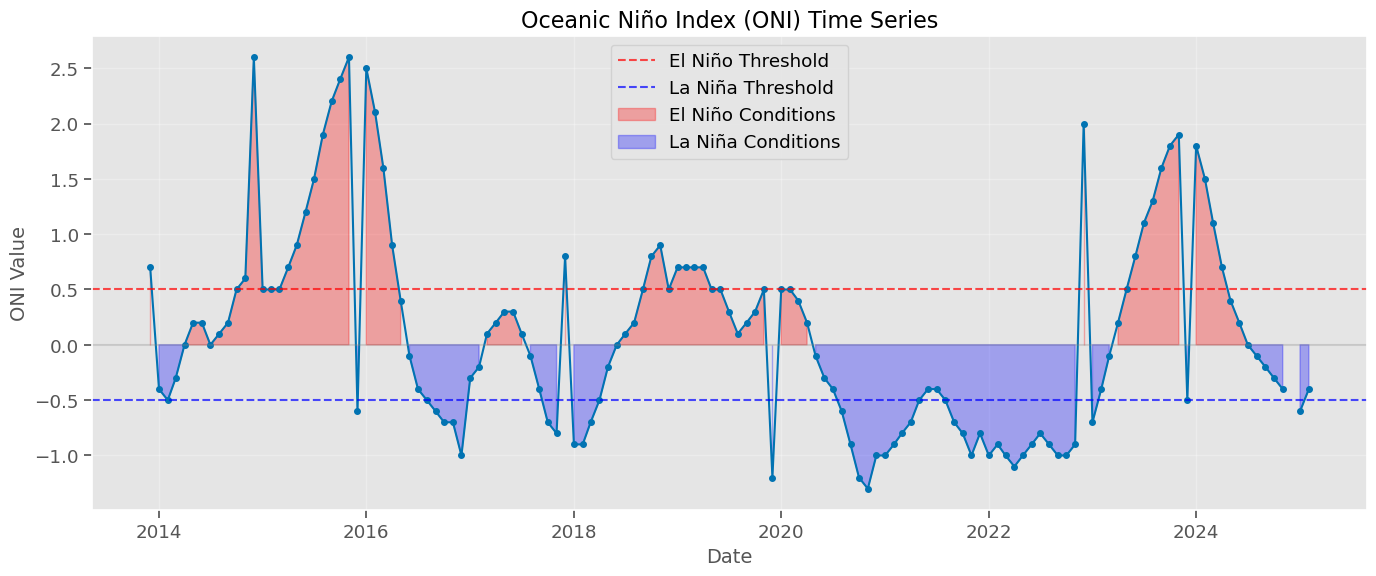

In [20]:
def process_oni_data(df):
    """
    Process ONI (El Niño/La Niña) data.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Raw ONI data in wide format
        
    Returns:
    --------
    pandas.DataFrame, pandas.DataFrame
        Processed ONI data in long format and seasonal ONI averages
    """
    print("Processing ONI (El Niño/La Niña) data...")
    
    # Reshape from wide to long format
    oni_long = pd.melt(df, id_vars=['Year'], 
                      value_vars=['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 
                                 'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ'],
                      var_name='Month_Group', value_name='ONI')
    
    # Create mapping for central month of each 3-month group
    month_mapping = {
        'DJF': 1,   # January
        'JFM': 2,   # February
        'FMA': 3,   # March
        'MAM': 4,   # April
        'AMJ': 5,   # May
        'MJJ': 6,   # June
        'JJA': 7,   # July
        'JAS': 8,   # August
        'ASO': 9,   # September
        'SON': 10,  # October
        'OND': 11,  # November
        'NDJ': 12   # December
    }
    
    # Add month number
    oni_long['Month'] = oni_long['Month_Group'].map(month_mapping)
    
    # Create date for first day of the central month
    oni_long['Date'] = pd.to_datetime(oni_long.apply(
        lambda x: f"{x['Year']}-{x['Month']}-01" if x['Month'] < 12 
                else f"{x['Year']-1}-{x['Month']}-01", axis=1))
    
    # Sort by date
    oni_long = oni_long.sort_values('Date').reset_index(drop=True)
    
    # Create ski season identifier matching our other datasets
    oni_long['SKI_SEASON'] = oni_long['Date'].apply(
        lambda x: f"{x.year}-{x.year+1}" if x.month >= 7 else f"{x.year-1}-{x.year}"
    )
    
    # Calculate seasonal ONI averages (winter months: Nov-Apr)
    winter_months = [11, 12, 1, 2, 3, 4]
    oni_seasonal = oni_long[oni_long['Month'].isin(winter_months)].groupby('SKI_SEASON')['ONI'].mean().reset_index()
    oni_seasonal.rename(columns={'ONI': 'SEASONAL_ONI'}, inplace=True)
    
    return oni_long, oni_seasonal

# Process ONI data
oni_long, oni_seasonal = process_oni_data(oni_df)

# Display samples of processed ONI data
print("\nSample of processed ONI data (long format):")
display(oni_long.head())

print("\nSample of seasonal ONI averages:")
display(oni_seasonal.head())

# Visualize ONI trends
plt.figure(figsize=(14, 6))
plt.plot(oni_long['Date'], oni_long['ONI'], marker='o', linestyle='-', markersize=4)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='El Niño Threshold')
plt.axhline(y=-0.5, color='blue', linestyle='--', alpha=0.7, label='La Niña Threshold')
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.fill_between(oni_long['Date'], oni_long['ONI'], 0, where=oni_long['ONI'] >= 0, color='red', alpha=0.3, label='El Niño Conditions')
plt.fill_between(oni_long['Date'], oni_long['ONI'], 0, where=oni_long['ONI'] <= 0, color='blue', alpha=0.3, label='La Niña Conditions')
plt.title('Oceanic Niño Index (ONI) Time Series', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('ONI Value', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Feature Engineering

To capture the complex relationships between weather patterns and ski season characteristics, we need to create derived features that represent meaningful aspects of the environment. This section focuses on:

1. **Rolling window statistics**: Capturing weather trends over different time periods
2. **Seasonal cumulative metrics**: Tracking total seasonal snowfall, precipitation, etc.
3. **Freeze day calculations**: Quantifying cold periods conducive to snowmaking
4. **Integrated climate indicators**: Merging ONI data with local weather patterns

These engineered features will help our models understand both short-term weather fluctuations and longer-term climate patterns that influence ski season length.

In [23]:
def create_complete_weather_dataset(weather_df):
    """
    Create a complete dataset with all dates for all stations,
    filling missing values appropriately.
    
    Parameters:
    -----------
    weather_df : pandas.DataFrame
        Processed weather data
        
    Returns:
    --------
    pandas.DataFrame
        Complete weather dataset with no missing dates
    """
    print("Creating complete weather dataset with all dates...")
    
    # Group by station and date
    station_daily = weather_df.groupby(['STATION', 'DATE']).agg({
        'PRCP': 'mean',       # Average precipitation across readings
        'SNOW': 'mean',       # Average new snowfall
        'SNWD': 'mean',       # Average snow depth
        'TMAX': 'mean',       # Maximum temperature
        'TMIN': 'mean',       # Minimum temperature
        'TAVG': lambda x: pd.to_numeric(x, errors='coerce').mean(),  # Handle non-numeric values
        'YEAR': 'first',      # These values should be constant within a day
        'MONTH': 'first',
        'DAY': 'first',
        'DOY': 'first',
        'SEASON': 'first',
        'WINTER_DAY': 'first'
    }).reset_index()
    
    # Create a date range spanning the entire dataset
    date_range = pd.date_range(start=weather_df['DATE'].min(), end=weather_df['DATE'].max(), freq='D')
    all_stations = weather_df['STATION'].unique()
    
    # Create a complete dataframe with all dates for all stations
    date_stations = pd.MultiIndex.from_product([all_stations, date_range], names=['STATION', 'DATE'])
    complete_df = pd.DataFrame(index=date_stations).reset_index()
    
    # Merge with the actual data
    complete_df = complete_df.merge(station_daily, on=['STATION', 'DATE'], how='left')
    
    # Define winter day function for filling missing values
    def winter_day(date):
        year = date.year
        nov1 = datetime(year, 11, 1)
        if date.month < 11:
            nov1 = datetime(year-1, 11, 1)
        return (date - nov1).days + 1
    
    # Fill in missing year, month, day values for dates without data
    complete_df['YEAR'] = complete_df['YEAR'].fillna(complete_df['DATE'].dt.year)
    complete_df['MONTH'] = complete_df['MONTH'].fillna(complete_df['DATE'].dt.month)
    complete_df['DAY'] = complete_df['DAY'].fillna(complete_df['DATE'].dt.day)
    complete_df['DOY'] = complete_df['DOY'].fillna(complete_df['DATE'].dt.dayofyear)
    
    # Fill in missing SEASON values
    complete_df['SEASON'] = complete_df['SEASON'].fillna(complete_df['DATE'].apply(
        lambda x: f"{x.year}-{x.year+1}" if x.month >= 7 else f"{x.year-1}-{x.year}"
    ))
    
    # Calculate WINTER_DAY if missing
    complete_df['WINTER_DAY'] = complete_df['WINTER_DAY'].fillna(complete_df['DATE'].apply(winter_day))
    
    return complete_df

# Create complete dataset
complete_df = create_complete_weather_dataset(weather_df)

# Display sample of complete dataset
print("\nSample of complete weather dataset:")
display(complete_df.head())

# Check for any remaining missing date values
print("\nMissing date-related values after processing:")
missing_date_values = complete_df[['YEAR', 'MONTH', 'DAY', 'DOY', 'SEASON', 'WINTER_DAY']].isnull().sum()
display(missing_date_values)

Creating complete weather dataset with all dates...

Sample of complete weather dataset:


,STATION,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TAVG,YEAR,MONTH,DAY,DOY,SEASON,WINTER_DAY
0,USC00048758,2014-01-01,0.0,0.0,1.0,49.0,22.0,NaN,2014.0,1.0,1.0,1.0,2013-2014,62.0
1,USC00048758,2014-01-02,0.0,0.0,1.0,47.0,22.0,NaN,2014.0,1.0,2.0,2.0,2013-2014,63.0
2,USC00048758,2014-01-03,0.0,0.0,1.0,46.0,24.0,NaN,2014.0,1.0,3.0,3.0,2013-2014,64.0
3,USC00048758,2014-01-04,0.0,0.0,1.0,47.0,23.0,NaN,2014.0,1.0,4.0,4.0,2013-2014,65.0
4,USC00048758,2014-01-05,0.0,0.0,1.0,45.0,20.0,NaN,2014.0,1.0,5.0,5.0,2013-2014,66.0



Missing date-related values after processing:


YEAR          0
MONTH         0
DAY           0
DOY           0
SEASON        0
WINTER_DAY    0
dtype: int64

In [25]:
def create_rolling_statistics(complete_df, all_stations):
    """
    Calculate rolling window statistics for weather variables.
    
    Parameters:
    -----------
    complete_df : pandas.DataFrame
        Complete weather dataset
    all_stations : array-like
        List of unique weather stations
        
    Returns:
    --------
    pandas.DataFrame
        Weather dataset with added rolling statistics
    """
    print("Creating rolling window statistics...")
    
    # Define window sizes to analyze (days)
    windows = [7, 14, 30]
    
    # For each window size
    for window in windows:
        print(f"  Calculating {window}-day window statistics...")
        
        # For each station
        for station in all_stations:
            # Create a mask for the current station
            station_mask = complete_df['STATION'] == station
            
            # Get data for the current station, sorted by date
            station_data = complete_df[station_mask].sort_values('DATE')
            
            # Calculate rolling averages for temperature
            complete_df.loc[station_mask, f'TMAX_{window}d_AVG'] = station_data['TMAX'].rolling(window, min_periods=1).mean()
            complete_df.loc[station_mask, f'TMIN_{window}d_AVG'] = station_data['TMIN'].rolling(window, min_periods=1).mean()
            
            # Calculate cumulative precipitation and snow
            complete_df.loc[station_mask, f'PRCP_{window}d_SUM'] = station_data['PRCP'].rolling(window, min_periods=1).sum()
            complete_df.loc[station_mask, f'SNOW_{window}d_SUM'] = station_data['SNOW'].rolling(window, min_periods=1).sum()
            
            # Calculate number of freeze days in rolling window (TMIN ≤ 32°F)
            complete_df.loc[station_mask, f'FREEZE_DAYS_{window}d'] = station_data['TMIN'].rolling(window, min_periods=1).apply(
                lambda x: (x <= 32).sum())
    
    return complete_df

# Create rolling statistics
all_stations = weather_df['STATION'].unique()
complete_df = create_rolling_statistics(complete_df, all_stations)

# Display a sample with new features
print("\nSample of dataset with rolling window statistics:")
display(complete_df[['DATE', 'STATION', 'TMAX', 'TMIN', 'TMAX_7d_AVG', 'TMIN_7d_AVG', 
                    'PRCP_7d_SUM', 'SNOW_7d_SUM', 'FREEZE_DAYS_7d']].head())

Creating rolling window statistics...
  Calculating 7-day window statistics...
  Calculating 14-day window statistics...
  Calculating 30-day window statistics...

Sample of dataset with rolling window statistics:


,DATE,STATION,TMAX,TMIN,TMAX_7d_AVG,TMIN_7d_AVG,PRCP_7d_SUM,SNOW_7d_SUM,FREEZE_DAYS_7d
0,2014-01-01,USC00048758,49.0,22.0,49.000000,22.000000,0.0,0.0,1.0
1,2014-01-02,USC00048758,47.0,22.0,48.000000,22.000000,0.0,0.0,2.0
2,2014-01-03,USC00048758,46.0,24.0,47.333333,22.666667,0.0,0.0,3.0
3,2014-01-04,USC00048758,47.0,23.0,47.250000,22.750000,0.0,0.0,4.0
4,2014-01-05,USC00048758,45.0,20.0,46.800000,22.200000,0.0,0.0,5.0


In [27]:
def calculate_seasonal_metrics(complete_df):
    """
    Calculate cumulative seasonal metrics for each station.
    
    Parameters:
    -----------
    complete_df : pandas.DataFrame
        Weather dataset with rolling statistics
        
    Returns:
    --------
    pandas.DataFrame
        Weather dataset with added seasonal cumulative metrics
    """
    print("Calculating seasonal cumulative metrics...")
    
    # Group by station and season
    seasonal_groups = complete_df.groupby(['STATION', 'SEASON'])
    
    # Initialize columns for cumulative seasonal values
    complete_df['CUM_SNOW'] = np.nan
    complete_df['CUM_PRCP'] = np.nan
    complete_df['DAYS_BELOW_FREEZING'] = np.nan
    
    # Calculate cumulative values within each season for each station
    for (station, season), group in seasonal_groups:
        # Sort the group by date
        group = group.sort_values('DATE')
        
        # Create a mask for the current station and season
        mask = (complete_df['STATION'] == station) & (complete_df['SEASON'] == season)
        
        # Cumulative snow and precipitation for the season
        complete_df.loc[mask, 'CUM_SNOW'] = group['SNOW'].fillna(0).cumsum()
        complete_df.loc[mask, 'CUM_PRCP'] = group['PRCP'].fillna(0).cumsum()
        
        # Count of days below freezing in the season so far
        complete_df.loc[mask, 'DAYS_BELOW_FREEZING'] = group['TMIN'].fillna(100).apply(
            lambda x: 1 if x <= 32 else 0).cumsum()
    
    return complete_df

# Calculate seasonal metrics
complete_df = calculate_seasonal_metrics(complete_df)

# Display a sample with new seasonal features
print("\nSample of dataset with seasonal cumulative metrics:")
display(complete_df[['DATE', 'STATION', 'SEASON', 'SNOW', 'CUM_SNOW', 'PRCP', 
                    'CUM_PRCP', 'DAYS_BELOW_FREEZING']].head(10))

Calculating seasonal cumulative metrics...

Sample of dataset with seasonal cumulative metrics:


,DATE,STATION,SEASON,SNOW,CUM_SNOW,PRCP,CUM_PRCP,DAYS_BELOW_FREEZING
0,2014-01-01,USC00048758,2013-2014,0.0,0.0,0.0,0.0,1.0
1,2014-01-02,USC00048758,2013-2014,0.0,0.0,0.0,0.0,2.0
2,2014-01-03,USC00048758,2013-2014,0.0,0.0,0.0,0.0,3.0
3,2014-01-04,USC00048758,2013-2014,0.0,0.0,0.0,0.0,4.0
4,2014-01-05,USC00048758,2013-2014,0.0,0.0,0.0,0.0,5.0
5,2014-01-06,USC00048758,2013-2014,0.0,0.0,0.0,0.0,6.0
6,2014-01-07,USC00048758,2013-2014,0.0,0.0,0.0,0.0,7.0
7,2014-01-08,USC00048758,2013-2014,0.0,0.0,0.0,0.0,8.0
8,2014-01-09,USC00048758,2013-2014,0.0,0.0,0.0,0.0,9.0
9,2014-01-10,USC00048758,2013-2014,0.0,0.0,0.0,0.0,10.0


In [29]:
def integrate_oni_data(complete_df, oni_long, oni_seasonal):
    """
    Merge ONI (El Niño/La Niña) data with weather dataset.
    
    Parameters:
    -----------
    complete_df : pandas.DataFrame
        Weather dataset with seasonal metrics
    oni_long : pandas.DataFrame
        ONI data in long format
    oni_seasonal : pandas.DataFrame
        Seasonal ONI averages
        
    Returns:
    --------
    pandas.DataFrame
        Integrated dataset with weather and climate indicators
    """
    print("Integrating ONI climate indicators...")
    
    # Create month-year identifier for weather data
    complete_df['YearMonth'] = complete_df['DATE'].dt.to_period('M')
    oni_long['YearMonth'] = oni_long['Date'].dt.to_period('M')
    
    # Merge monthly ONI values
    complete_df = complete_df.merge(oni_long[['YearMonth', 'ONI']], on='YearMonth', how='left')
    
    # Add ski season identifier to match with seasonal ONI
    complete_df['SKI_SEASON'] = complete_df['DATE'].apply(
        lambda x: f"{x.year}-{x.year+1}" if x.month >= 7 else f"{x.year-1}-{x.year}"
    )
    
    # Merge seasonal ONI values
    complete_df = complete_df.merge(oni_seasonal, on='SKI_SEASON', how='left')
    
    # Clean up intermediate columns
    complete_df.drop('YearMonth', axis=1, inplace=True)
    
    return complete_df

# Integrate ONI data
complete_df = integrate_oni_data(complete_df, oni_long, oni_seasonal)

# Display a sample with integrated ONI data
print("\nSample of dataset with integrated ONI indicators:")
display(complete_df[['DATE', 'STATION', 'SEASON', 'SKI_SEASON', 'ONI', 'SEASONAL_ONI']].head())

Integrating ONI climate indicators...

Sample of dataset with integrated ONI indicators:


,DATE,STATION,SEASON,SKI_SEASON,ONI,SEASONAL_ONI
0,2014-01-01,USC00048758,2013-2014,2013-2014,-0.4,-0.1
1,2014-01-02,USC00048758,2013-2014,2013-2014,-0.4,-0.1
2,2014-01-03,USC00048758,2013-2014,2013-2014,-0.4,-0.1
3,2014-01-04,USC00048758,2013-2014,2013-2014,-0.4,-0.1
4,2014-01-05,USC00048758,2013-2014,2013-2014,-0.4,-0.1


In [31]:
def aggregate_daily_data(complete_df):
    """
    Aggregate data across all stations to create a single daily time series.
    
    Parameters:
    -----------
    complete_df : pandas.DataFrame
        Complete weather dataset with all features
        
    Returns:
    --------
    pandas.DataFrame
        Daily average dataset across all stations
    """
    print("Aggregating data across all stations...")
    
    # Columns to aggregate
    agg_columns = {
        # Basic weather measurements
        'PRCP': 'mean',
        'SNOW': 'mean',
        'SNWD': 'mean',
        'TMAX': 'mean',
        'TMIN': 'mean',
        'TAVG': 'mean',
        
        # Rolling window statistics
        'TMAX_7d_AVG': 'mean',
        'TMIN_7d_AVG': 'mean',
        'PRCP_7d_SUM': 'mean',
        'SNOW_7d_SUM': 'mean',
        'FREEZE_DAYS_7d': 'mean',
        'TMAX_14d_AVG': 'mean',
        'TMIN_14d_AVG': 'mean',
        'PRCP_14d_SUM': 'mean',
        'SNOW_14d_SUM': 'mean',
        'FREEZE_DAYS_14d': 'mean',
        'TMAX_30d_AVG': 'mean',
        'TMIN_30d_AVG': 'mean',
        'PRCP_30d_SUM': 'mean',
        'SNOW_30d_SUM': 'mean',
        'FREEZE_DAYS_30d': 'mean',
        
        # Cumulative seasonal metrics
        'CUM_SNOW': 'mean',
        'CUM_PRCP': 'mean',
        'DAYS_BELOW_FREEZING': 'mean',
        
        # Date components and identifiers
        'YEAR': 'first',
        'MONTH': 'first',
        'DAY': 'first',
        'DOY': 'first',
        'SEASON': 'first',
        'WINTER_DAY': 'first',
        
        # Climate indicators
        'ONI': 'first',
        'SKI_SEASON': 'first',
        'SEASONAL_ONI': 'first'
    }
    
    # Group by date and aggregate
    daily_avg = complete_df.groupby('DATE').agg(agg_columns).reset_index()
    
    return daily_avg

# Aggregate daily data
daily_avg = aggregate_daily_data(complete_df)

# Display a sample of daily aggregated data
print("\nSample of daily aggregated data:")
display(daily_avg.head())

Aggregating data across all stations...

Sample of daily aggregated data:


,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TAVG,TMAX_7d_AVG,TMIN_7d_AVG,PRCP_7d_SUM,SNOW_7d_SUM,FREEZE_DAYS_7d,TMAX_14d_AVG,TMIN_14d_AVG,PRCP_14d_SUM,SNOW_14d_SUM,FREEZE_DAYS_14d,TMAX_30d_AVG,TMIN_30d_AVG,PRCP_30d_SUM,SNOW_30d_SUM,FREEZE_DAYS_30d,CUM_SNOW,CUM_PRCP,DAYS_BELOW_FREEZING,YEAR,MONTH,DAY,DOY,SEASON,WINTER_DAY,ONI,SKI_SEASON,SEASONAL_ONI
0,2014-01-01,0.0,0.0,1.4,51.166667,18.500000,NaN,51.166667,18.500000,0.0,0.0,1.0,51.166667,18.500000,0.0,0.0,1.0,51.166667,18.500000,0.0,0.0,1.0,0.0,0.0,0.857143,2014.0,1.0,1.0,1.0,2013-2014,62.0,-0.4,2013-2014,-0.1
1,2014-01-02,0.0,0.0,1.4,50.000000,18.166667,NaN,50.583333,18.333333,0.0,0.0,2.0,50.583333,18.333333,0.0,0.0,2.0,50.583333,18.333333,0.0,0.0,2.0,0.0,0.0,1.714286,2014.0,1.0,2.0,2.0,2013-2014,63.0,-0.4,2013-2014,-0.1
2,2014-01-03,0.0,0.0,1.4,51.000000,19.666667,NaN,50.722222,18.777778,0.0,0.0,3.0,50.722222,18.777778,0.0,0.0,3.0,50.722222,18.777778,0.0,0.0,3.0,0.0,0.0,2.571429,2014.0,1.0,3.0,3.0,2013-2014,64.0,-0.4,2013-2014,-0.1
3,2014-01-04,0.0,0.0,1.4,48.833333,19.666667,NaN,50.250000,19.000000,0.0,0.0,4.0,50.250000,19.000000,0.0,0.0,4.0,50.250000,19.000000,0.0,0.0,4.0,0.0,0.0,3.428571,2014.0,1.0,4.0,4.0,2013-2014,65.0,-0.4,2013-2014,-0.1
4,2014-01-05,0.0,0.0,1.4,44.166667,14.666667,NaN,49.033333,18.133333,0.0,0.0,5.0,49.033333,18.133333,0.0,0.0,5.0,49.033333,18.133333,0.0,0.0,5.0,0.0,0.0,4.285714,2014.0,1.0,5.0,5.0,2013-2014,66.0,-0.4,2013-2014,-0.1


## Seasonal Analysis Dataset

To predict ski season length, we need to structure our data at the resort-season level. For each resort and season, we'll calculate:

1. **Pre-season conditions**: Weather patterns from November 1 to the opening date
2. **Seasonal totals**: Total snowfall, precipitation, and freeze days during the entire season
3. **Climate indicators**: Average ONI values for the winter season
4. **Snow depth at opening**: Snow conditions when the resort started operations

This dataset will directly link weather and climate patterns to season length for modeling.

In [34]:
def calculate_seasonal_totals(daily_avg, resort_df):
    """
    Calculate total seasonal snow and other metrics for each resort/season.
    
    Parameters:
    -----------
    daily_avg : pandas.DataFrame
        Daily aggregated weather data
    resort_df : pandas.DataFrame
        Processed resort data
        
    Returns:
    --------
    dict
        Dictionary of seasonal totals by resort and season
    """
    print("Calculating actual seasonal snow totals...")
    
    # Create a dictionary to store total seasonal snow for each resort/season
    seasonal_totals = {}
    
    # For each resort and season
    for _, row in resort_df.iterrows():
        resort = row['Resort']
        season = row['Season']
        opening_date = row['OPENING_DATE']
        closing_date = row['CLOSING_DATE']
        
        # Get weather data for the entire season (opening to closing)
        season_weather = daily_avg[(daily_avg['DATE'] >= opening_date) & 
                                  (daily_avg['DATE'] <= closing_date)]
        
        # Calculate total snowfall, precipitation, and freezing days for the season
        if len(season_weather) > 0:
            total_snow = season_weather['SNOW'].fillna(0).sum()
            total_prcp = season_weather['PRCP'].fillna(0).sum()
            freeze_days = (season_weather['TMIN'] <= 32).sum()
            avg_tmax = season_weather['TMAX'].mean()
            avg_tmin = season_weather['TMIN'].mean()
            
            # Get average ONI for the season
            season_oni = season_weather['SEASONAL_ONI'].mean()
            
            # Store in dictionary
            seasonal_totals[(resort, season)] = {
                'TOTAL_SNOW': total_snow,
                'TOTAL_PRCP': total_prcp,
                'FREEZE_DAYS': freeze_days,
                'AVG_TMAX': avg_tmax,
                'AVG_TMIN': avg_tmin,
                'SEASON_ONI': season_oni
            }
    
    return seasonal_totals

def create_seasonal_analysis_dataset(daily_avg, resort_df, seasonal_totals):
    """
    Create a dataset with pre-season conditions for each resort/season.
    
    Parameters:
    -----------
    daily_avg : pandas.DataFrame
        Daily aggregated weather data
    resort_df : pandas.DataFrame
        Processed resort data
    seasonal_totals : dict
        Dictionary of seasonal totals by resort and season
        
    Returns:
    --------
    pandas.DataFrame
        Dataset with pre-season conditions and seasonal metrics
    """
    print("Preparing seasonal analysis dataset...")
    
    # Create a dataframe with pre-season conditions for each resort/season
    pre_season_data = []
    
    for _, row in resort_df.iterrows():
        resort = row['Resort']
        season = row['Season']
        opening_date = row['OPENING_DATE']
        closing_date = row['CLOSING_DATE']
        season_length = row['SEASON_LENGTH']
        
        # Get Nov 1 of that season
        year = opening_date.year
        if opening_date.month < 7:
            year = year - 1
        nov1 = datetime(year, 11, 1)
        
        # Get pre-season conditions (Nov 1 to opening date)
        preseason = daily_avg[(daily_avg['DATE'] >= nov1) & 
                             (daily_avg['DATE'] < opening_date)]
        
        if len(preseason) > 0:
            # Calculate pre-season metrics
            preseason_snow = preseason['SNOW'].fillna(0).sum()
            preseason_prcp = preseason['PRCP'].fillna(0).sum()
            preseason_freeze_days = (preseason['TMIN'] <= 32).sum()
            
            # Get the most recent snow depth before opening
            last_day = preseason.iloc[-1]
            snow_depth_at_opening = last_day['SNWD']
            
            # Get seasonal ONI value
            season_oni = last_day['SEASONAL_ONI']
            
            # Get season totals if available
            total_metrics = seasonal_totals.get((resort, season), {})
            
            # Create entry
            pre_season_data.append({
                'Resort': resort,
                'Season': season,
                'Opening_Date': opening_date,
                'Closing_Date': closing_date,
                'Season_Length': season_length,
                'Preseason_Snow': preseason_snow,
                'Preseason_Prcp': preseason_prcp,
                'Preseason_Freeze_Days': preseason_freeze_days,
                'Snow_Depth_At_Opening': snow_depth_at_opening,
                'Seasonal_ONI': season_oni,
                'Total_Season_Snow': total_metrics.get('TOTAL_SNOW', np.nan),
                'Total_Season_Prcp': total_metrics.get('TOTAL_PRCP', np.nan),
                'Season_Freeze_Days': total_metrics.get('FREEZE_DAYS', np.nan),
                'Season_Avg_Tmax': total_metrics.get('AVG_TMAX', np.nan),
                'Season_Avg_Tmin': total_metrics.get('AVG_TMIN', np.nan)
            })
    
    # Convert to dataframe
    seasonal_df = pd.DataFrame(pre_season_data)
    
    return seasonal_df

# Calculate seasonal totals
seasonal_totals = calculate_seasonal_totals(daily_avg, resort_df)

# Create seasonal analysis dataset
seasonal_df = create_seasonal_analysis_dataset(daily_avg, resort_df, seasonal_totals)

# Display sample of seasonal analysis dataset
print("\nSample of seasonal analysis dataset:")
display(seasonal_df.head())

# Display summary statistics
print("\nSeasonal analysis dataset summary statistics:")
display(seasonal_df.describe())

Calculating actual seasonal snow totals...
Preparing seasonal analysis dataset...

Sample of seasonal analysis dataset:


,Resort,Season,Opening_Date,Closing_Date,Season_Length,Preseason_Snow,Preseason_Prcp,Preseason_Freeze_Days,Snow_Depth_At_Opening,Seasonal_ONI,Total_Season_Snow,Total_Season_Prcp,Season_Freeze_Days,Season_Avg_Tmax,Season_Avg_Tmin
0,Heavenly,2014/2015,2014-11-21,2015-04-19,149,0.916667,0.372857,18,0.000000,0.900000,19.800000,9.325714,138,49.564603,25.459365
1,Heavenly,2015/2016,2015-11-21,2016-04-24,155,10.950000,2.252857,19,0.333333,1.516667,133.783333,20.458571,144,44.649115,22.345391
2,Heavenly,2016/2017,2016-11-23,2017-04-30,158,1.133333,0.834286,19,0.000000,-0.316667,212.786667,46.358810,150,41.547020,21.697364
3,Heavenly,2017/2018,2017-11-17,2018-04-22,156,0.000000,3.965000,12,0.000000,-0.500000,114.781667,17.245952,144,45.293540,21.683985
4,Heavenly,2018/2019,2018-11-16,2019-05-27,192,0.000000,0.000000,15,0.000000,0.700000,217.545000,33.226381,170,43.807562,23.454552



Seasonal analysis dataset summary statistics:


,Opening_Date,Closing_Date,Season_Length,Preseason_Snow,Preseason_Prcp,Preseason_Freeze_Days,Snow_Depth_At_Opening,Seasonal_ONI,Total_Season_Snow,Total_Season_Prcp,Season_Freeze_Days,Season_Avg_Tmax,Season_Avg_Tmin
count,42,42,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,2019-11-25 16:34:17.142857216,2020-04-29 00:00:00,155.309524,6.493413,2.006259,21.857143,2.019444,0.146032,133.420675,20.831960,141.642857,44.591157,22.182796
min,2014-11-21 00:00:00,2015-03-21 00:00:00,99.000000,0.000000,0.000000,10.000000,0.000000,-0.966667,14.533333,5.575952,97.000000,39.265393,17.389703
25%,2016-11-25 00:00:00,2017-05-24 06:00:00,135.750000,1.133333,1.047083,16.250000,0.000000,-0.466667,83.521667,9.248750,127.250000,43.266615,21.148464
50%,2019-11-28 00:00:00,2020-03-14 00:00:00,149.500000,3.841667,1.927619,21.500000,0.450000,0.016667,123.226667,17.797500,144.000000,44.281005,21.999610
75%,2022-11-12 00:00:00,2023-05-05 06:00:00,170.500000,8.711667,2.573452,26.000000,2.125000,0.900000,208.228333,30.199000,153.000000,45.924867,23.030984
max,2024-11-29 00:00:00,2025-06-03 00:00:00,234.000000,24.250000,6.360714,39.000000,20.833333,1.516667,277.650000,47.775714,179.000000,51.047619,27.456028
std,NaN,NaN,32.138032,7.054437,1.324774,7.533896,3.873501,0.807383,76.260066,12.796067,20.706805,2.891329,2.103470


## Exploratory Data Analysis

Now that we have processed our data and created meaningful features, we can explore relationships between weather patterns, climate indicators, and ski season characteristics. This section will:

1. Analyze key relationships between weather metrics and season length
2. Explore the impact of El Niño/La Niña conditions on Tahoe skiing
3. Compare seasonal patterns across different resorts
4. Identify potential predictors for modeling

These visualizations will help us understand the complex relationships within our data and inform our modeling approach.

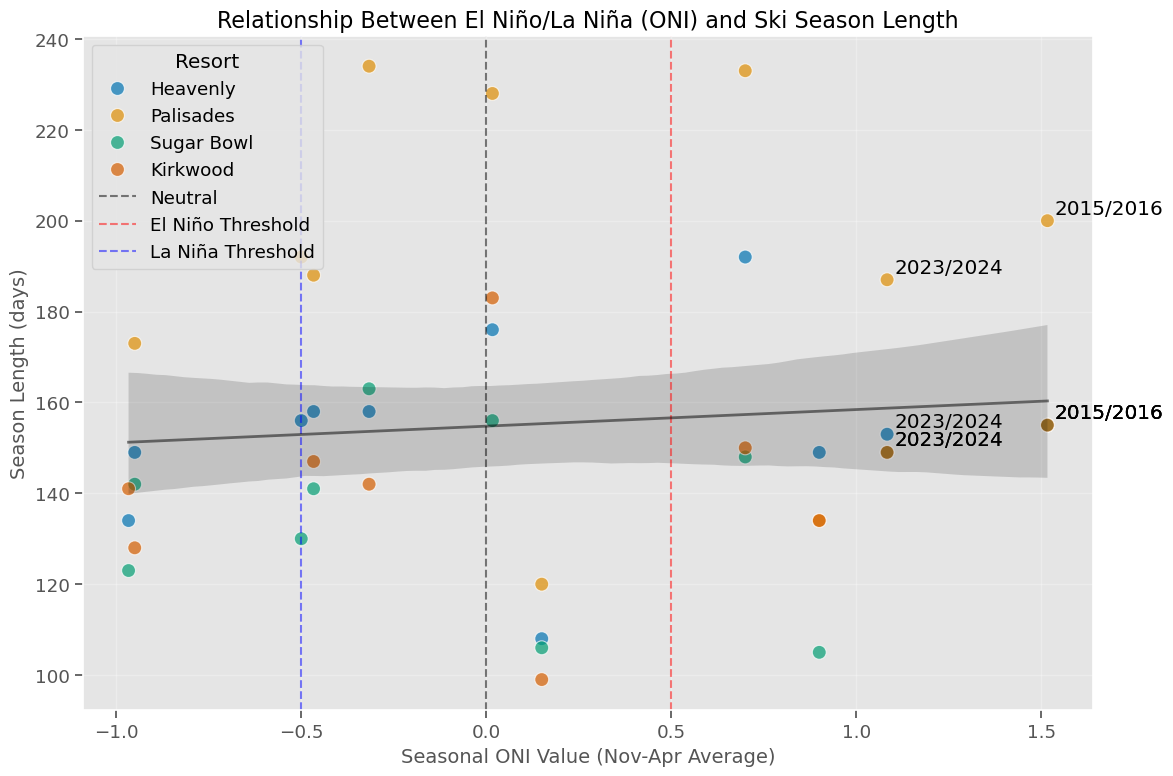

Correlation between Seasonal ONI and Season Length: 0.092

Average Season Length by ONI Condition:


,mean,std,count
ONI_Condition,,,
El Niño,159.2500,30.310614,16
La Niña,146.8000,21.709189,10
Neutral,156.6875,39.430477,16


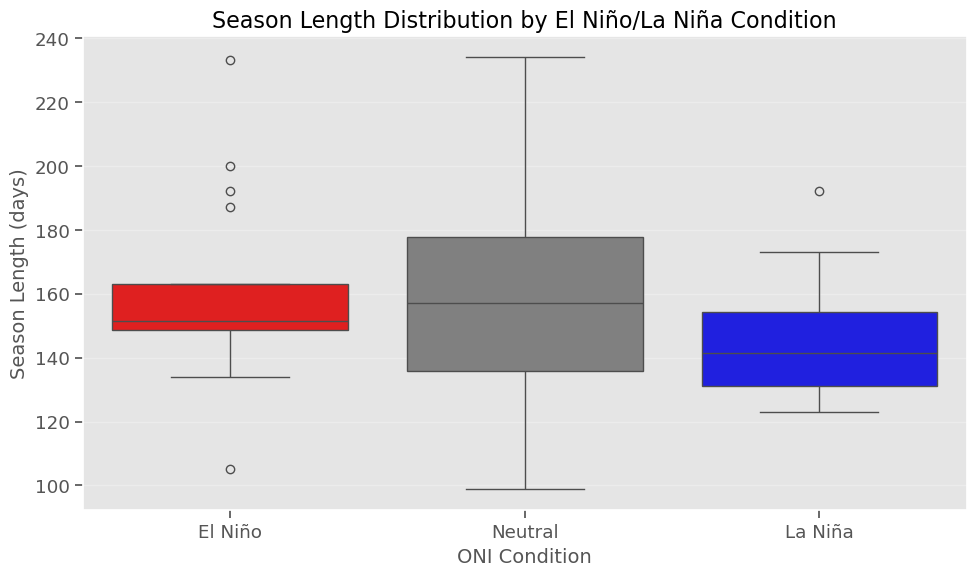

In [37]:
# Visualize relationship between seasonal ONI and season length
plt.figure(figsize=plt_figsize)
ax = sns.scatterplot(x='Seasonal_ONI', y='Season_Length', hue='Resort', 
                    data=seasonal_df, s=100, alpha=0.7)

# Add reference lines for El Niño/La Niña thresholds
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='Neutral')
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='El Niño Threshold')
plt.axvline(x=-0.5, color='blue', linestyle='--', alpha=0.5, label='La Niña Threshold')

# Annotate strong El Niño/La Niña seasons
for idx, row in seasonal_df.iterrows():
    if abs(row['Seasonal_ONI']) > 1.0:  # Strong El Niño or La Niña
        plt.annotate(f"{row['Season']}", 
                    (row['Seasonal_ONI'], row['Season_Length']),
                    xytext=(5, 5), textcoords='offset points')

# Add a trend line
sns.regplot(x='Seasonal_ONI', y='Season_Length', data=seasonal_df, 
           scatter=False, line_kws={"color": "black", "alpha": 0.5, "lw": 2})

plt.title('Relationship Between El Niño/La Niña (ONI) and Ski Season Length', fontsize=16)
plt.xlabel('Seasonal ONI Value (Nov-Apr Average)', fontsize=14)
plt.ylabel('Season Length (days)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Resort', loc='best')
plt.tight_layout()
plt.show()

# Calculate correlation between ONI and season length
oni_correlation = seasonal_df['Seasonal_ONI'].corr(seasonal_df['Season_Length'])
print(f"Correlation between Seasonal ONI and Season Length: {oni_correlation:.3f}")

# Group by ONI condition and analyze season length
def oni_condition(oni):
    if oni >= 0.5:
        return 'El Niño'
    elif oni <= -0.5:
        return 'La Niña'
    else:
        return 'Neutral'

seasonal_df['ONI_Condition'] = seasonal_df['Seasonal_ONI'].apply(oni_condition)

# Show average season length by ONI condition
oni_group = seasonal_df.groupby('ONI_Condition')['Season_Length'].agg(['mean', 'std', 'count'])
print("\nAverage Season Length by ONI Condition:")
display(oni_group)

# Visualize season length distribution by ONI condition
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='ONI_Condition', y='Season_Length', data=seasonal_df, 
                palette={'El Niño': 'red', 'Neutral': 'gray', 'La Niña': 'blue'})
plt.title('Season Length Distribution by El Niño/La Niña Condition', fontsize=16)
plt.xlabel('ONI Condition', fontsize=14)
plt.ylabel('Season Length (days)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

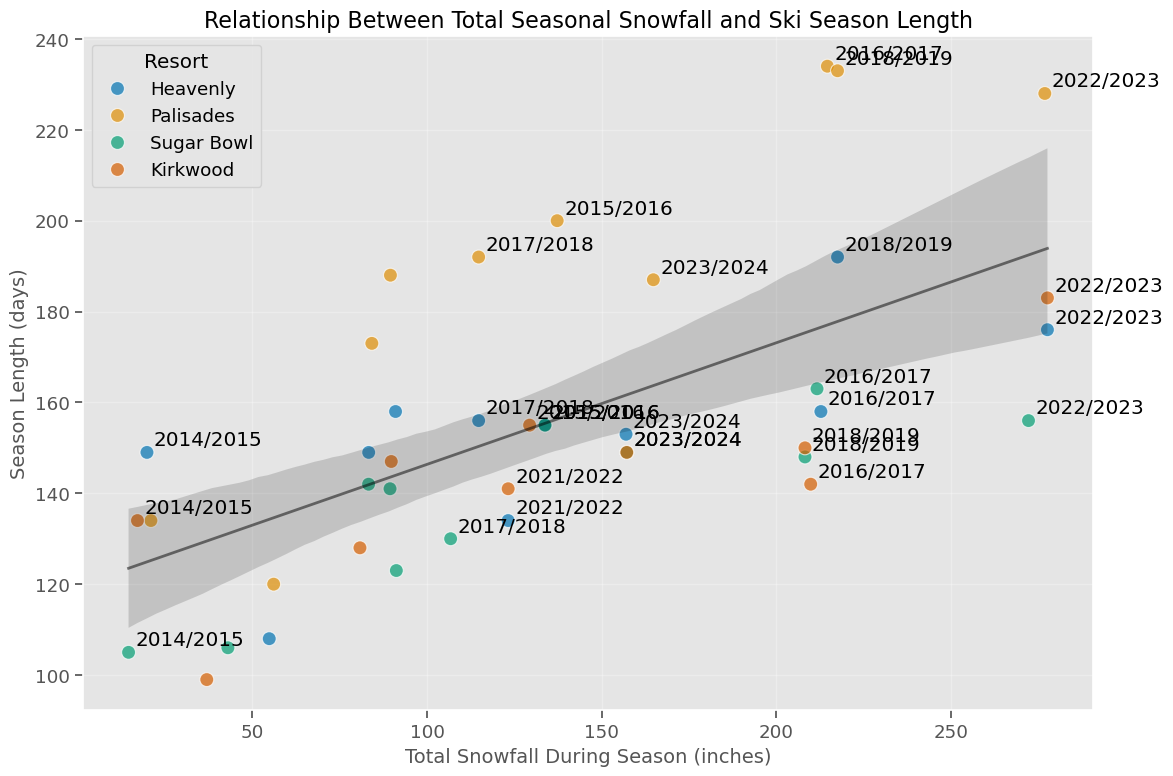

Correlation between Total Seasonal Snow and Season Length: 0.635

Average Season Length by Snow Category:


,mean,std,count
Snow_Category,,,
High Snow,163.764706,28.788738,34
Low Snow,130.500000,18.411953,4
Moderate Snow,108.250000,8.732125,4


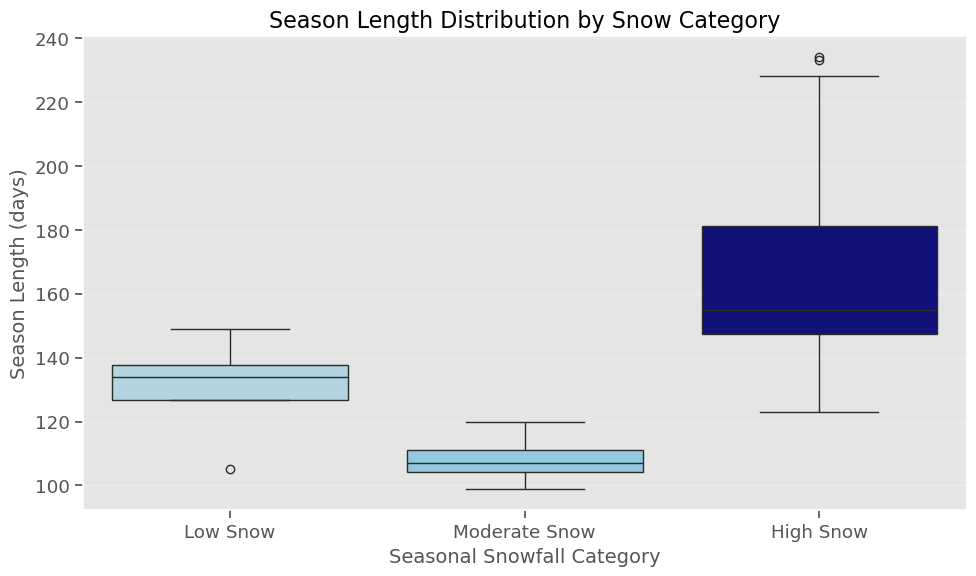

In [39]:
# Visualize relationship between total seasonal snow and season length
plt.figure(figsize=plt_figsize)
ax = sns.scatterplot(x='Total_Season_Snow', y='Season_Length', hue='Resort', 
                    data=seasonal_df, s=100, alpha=0.7)

# Add a trend line
sns.regplot(x='Total_Season_Snow', y='Season_Length', data=seasonal_df, 
           scatter=False, line_kws={"color": "black", "alpha": 0.5, "lw": 2})

# Annotate notable seasons (very high or low snowfall)
for idx, row in seasonal_df.iterrows():
    if row['Total_Season_Snow'] > 100 or row['Total_Season_Snow'] < 20:
        plt.annotate(f"{row['Season']}", 
                    (row['Total_Season_Snow'], row['Season_Length']),
                    xytext=(5, 5), textcoords='offset points')

plt.title('Relationship Between Total Seasonal Snowfall and Ski Season Length', fontsize=16)
plt.xlabel('Total Snowfall During Season (inches)', fontsize=14)
plt.ylabel('Season Length (days)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Resort', loc='best')
plt.tight_layout()
plt.show()

# Calculate correlation between total snow and season length
snow_correlation = seasonal_df['Total_Season_Snow'].corr(seasonal_df['Season_Length'])
print(f"Correlation between Total Seasonal Snow and Season Length: {snow_correlation:.3f}")

# Create snowfall categories for analysis
def snow_category(snow):
    if snow <= 30:
        return 'Low Snow'
    elif snow <= 70:
        return 'Moderate Snow'
    else:
        return 'High Snow'

seasonal_df['Snow_Category'] = seasonal_df['Total_Season_Snow'].apply(snow_category)

# Show average season length by snow category
snow_group = seasonal_df.groupby('Snow_Category')['Season_Length'].agg(['mean', 'std', 'count'])
print("\nAverage Season Length by Snow Category:")
display(snow_group)

# Visualize season length distribution by snow category
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Snow_Category', y='Season_Length', data=seasonal_df, 
                order=['Low Snow', 'Moderate Snow', 'High Snow'],
                palette={'Low Snow': 'lightblue', 'Moderate Snow': 'skyblue', 'High Snow': 'darkblue'})
plt.title('Season Length Distribution by Snow Category', fontsize=16)
plt.xlabel('Seasonal Snowfall Category', fontsize=14)
plt.ylabel('Season Length (days)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

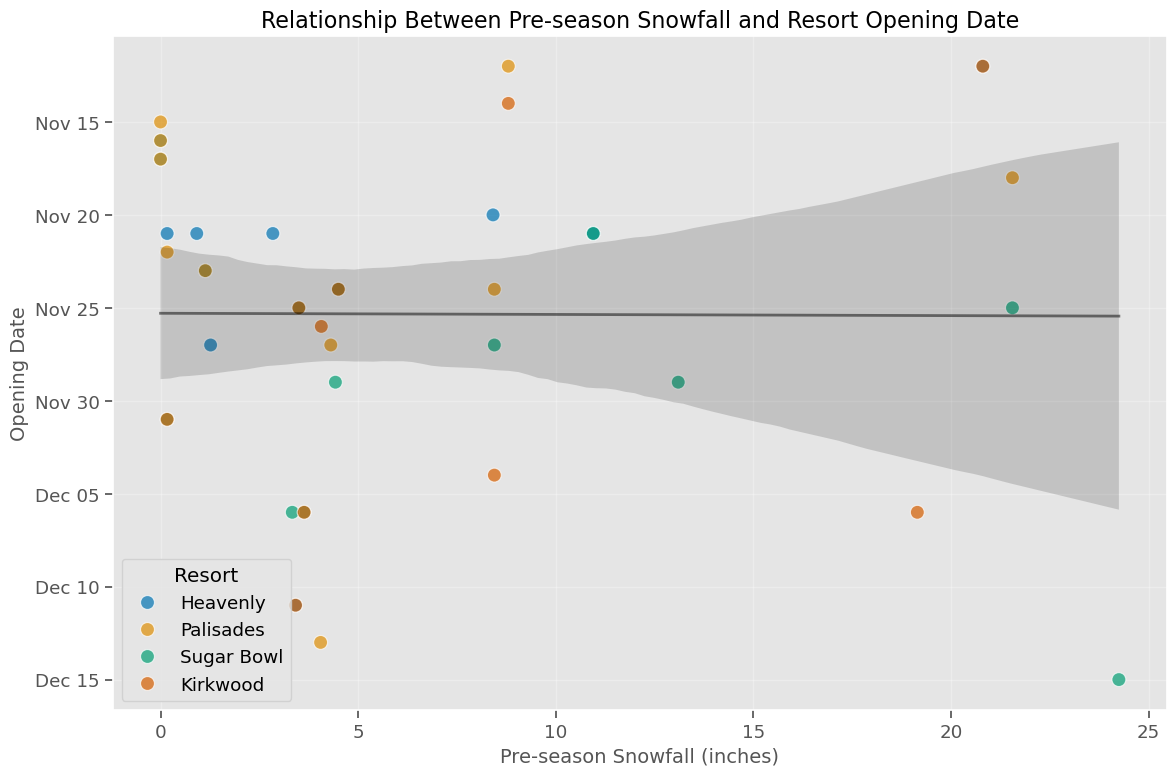

Correlation between Preseason Snow and Opening Date (winter day): 0.005

Average Opening Date (Winter Day) by Preseason Snow Quartile:


,mean,std,count
Preseason_Snow_Quartile,,,
Q1 (Lowest),21.083333,5.451577,12
Q2,32.000000,7.533260,9
Q3,27.800000,6.494442,10
Q4 (Highest),22.272727,10.789726,11


In [41]:
# First, convert opening date to a "winter day" for better visualization
seasonal_df['Opening_Winter_Day'] = seasonal_df['Opening_Date'].apply(
    lambda x: (x - datetime(x.year, 11, 1) if x.month >= 11 
              else x - datetime(x.year-1, 11, 1)).days + 1
)

# Visualize relationship between pre-season snow and opening date
plt.figure(figsize=plt_figsize)
ax = sns.scatterplot(x='Preseason_Snow', y='Opening_Winter_Day', hue='Resort', 
                    data=seasonal_df, s=100, alpha=0.7)

# Add a trend line
sns.regplot(x='Preseason_Snow', y='Opening_Winter_Day', data=seasonal_df, 
           scatter=False, line_kws={"color": "black", "alpha": 0.5, "lw": 2})

# Reverse y-axis so earlier dates are at the top
plt.gca().invert_yaxis()

# Create a custom y-tick formatter to show dates instead of winter days
from matplotlib.ticker import FuncFormatter

def winter_day_to_date(winter_day, pos):
    """Convert winter day to a date string."""
    nov1 = datetime(2020, 11, 1)  # Using arbitrary year
    date = nov1 + timedelta(days=winter_day-1)
    return date.strftime('%b %d')

ax.yaxis.set_major_formatter(FuncFormatter(winter_day_to_date))

plt.title('Relationship Between Pre-season Snowfall and Resort Opening Date', fontsize=16)
plt.xlabel('Pre-season Snowfall (inches)', fontsize=14)
plt.ylabel('Opening Date', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Resort', loc='best')
plt.tight_layout()
plt.show()

# Calculate correlation between preseason snow and opening day
opening_correlation = seasonal_df['Preseason_Snow'].corr(seasonal_df['Opening_Winter_Day'])
print(f"Correlation between Preseason Snow and Opening Date (winter day): {opening_correlation:.3f}")

# Show average opening date by preseason snow quartiles
seasonal_df['Preseason_Snow_Quartile'] = pd.qcut(seasonal_df['Preseason_Snow'], 4, 
                                               labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'])

opening_group = seasonal_df.groupby('Preseason_Snow_Quartile')['Opening_Winter_Day'].agg(['mean', 'std', 'count'])
print("\nAverage Opening Date (Winter Day) by Preseason Snow Quartile:")
display(opening_group)

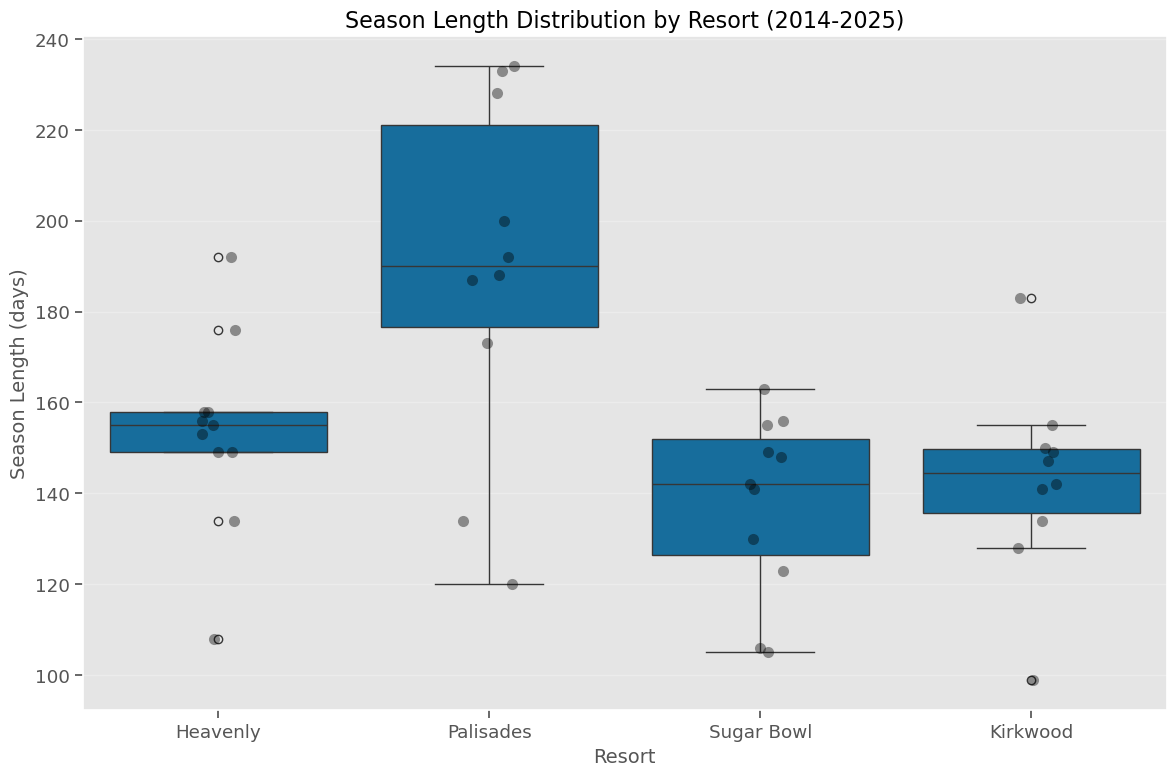


Season Length Statistics by Resort:


,mean,min,max,std
Resort,,,,
Heavenly,153.454545,108,192,21.280807
Kirkwood,142.800000,99,183,21.321872
Palisades,188.900000,120,234,38.957099
Sugar Bowl,138.000000,105,163,19.712940


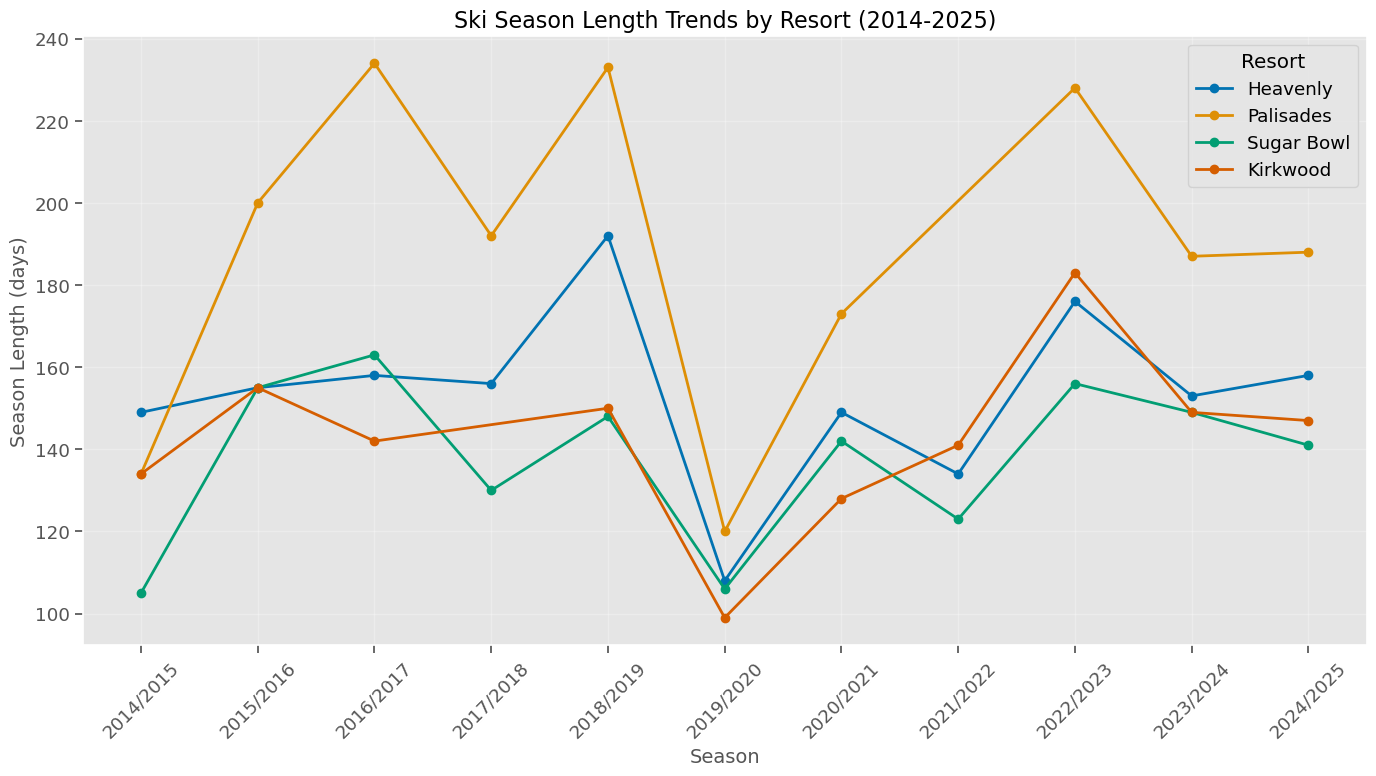


Correlation between Seasonal ONI and Season Length by Resort:


,Resort,ONI_Correlation
0,Heavenly,0.204352
1,Kirkwood,0.184773
2,Palisades,-0.048813
3,Sugar Bowl,0.095772


In [43]:
# Visualize season length distribution by resort
plt.figure(figsize=plt_figsize)
ax = sns.boxplot(x='Resort', y='Season_Length', data=seasonal_df)

# Add individual data points
sns.stripplot(x='Resort', y='Season_Length', data=seasonal_df, 
             size=8, color='black', alpha=0.4)

plt.title('Season Length Distribution by Resort (2014-2025)', fontsize=16)
plt.xlabel('Resort', fontsize=14)
plt.ylabel('Season Length (days)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate average season length by resort
resort_avg = seasonal_df.groupby('Resort')['Season_Length'].agg(['mean', 'min', 'max', 'std'])
print("\nSeason Length Statistics by Resort:")
display(resort_avg)

# Visualize season trends over time by resort
plt.figure(figsize=(14, 8))
for resort in seasonal_df['Resort'].unique():
    resort_data = seasonal_df[seasonal_df['Resort'] == resort].sort_values('Season')
    plt.plot(resort_data['Season'], resort_data['Season_Length'], 
             marker='o', linewidth=2, label=resort)

plt.title('Ski Season Length Trends by Resort (2014-2025)', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Season Length (days)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Resort')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate correlation between seasonal ONI and season length by resort
oni_by_resort = seasonal_df.groupby('Resort').apply(
    lambda x: x['Seasonal_ONI'].corr(x['Season_Length'])
).reset_index(name='ONI_Correlation')

print("\nCorrelation between Seasonal ONI and Season Length by Resort:")
display(oni_by_resort)

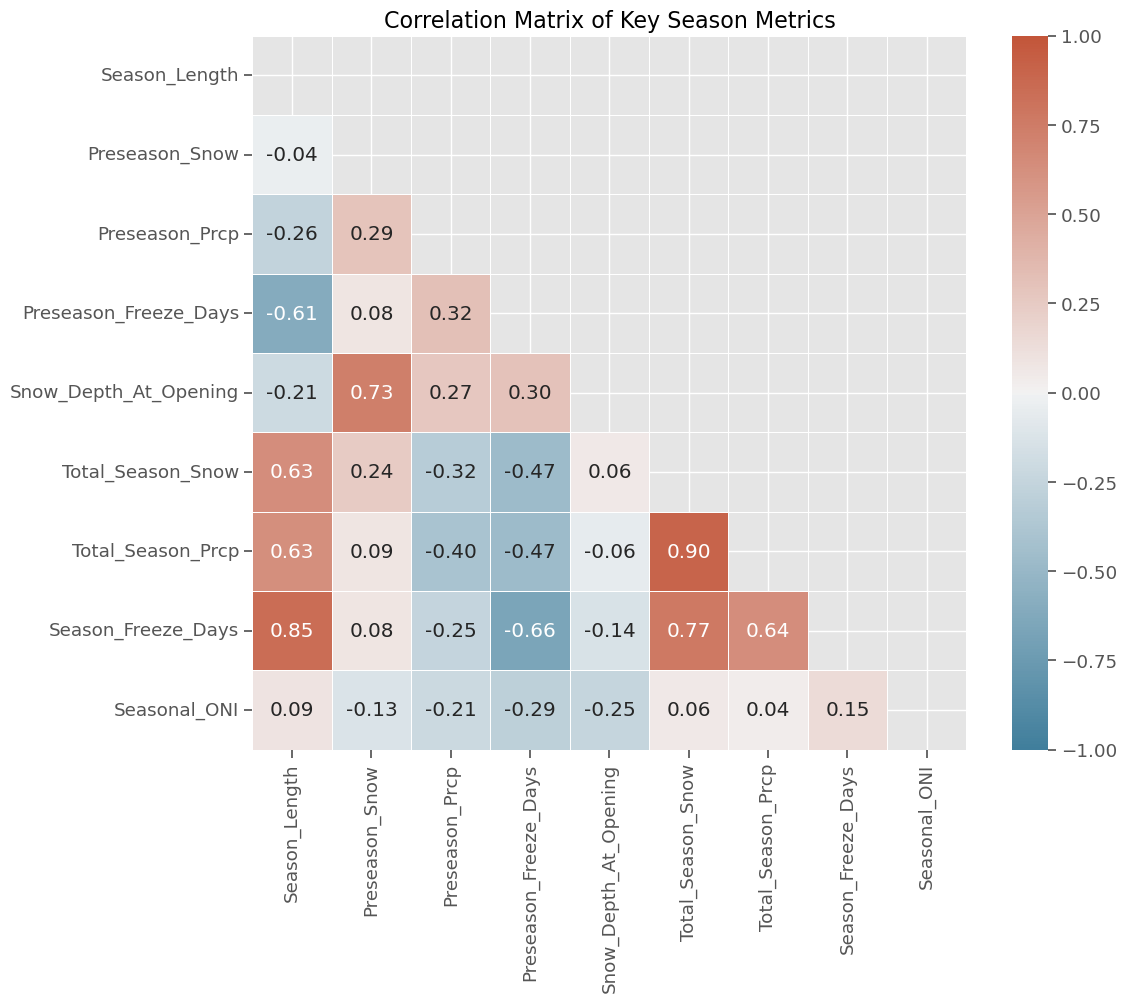


Features Most Correlated with Season Length:


Season_Freeze_Days       0.847134
Total_Season_Snow        0.634910
Total_Season_Prcp        0.625670
Seasonal_ONI             0.091837
Preseason_Snow          -0.035570
Snow_Depth_At_Opening   -0.206615
Preseason_Prcp          -0.259473
Preseason_Freeze_Days   -0.609356
Name: Season_Length, dtype: float64

<Figure size 1500x1200 with 0 Axes>

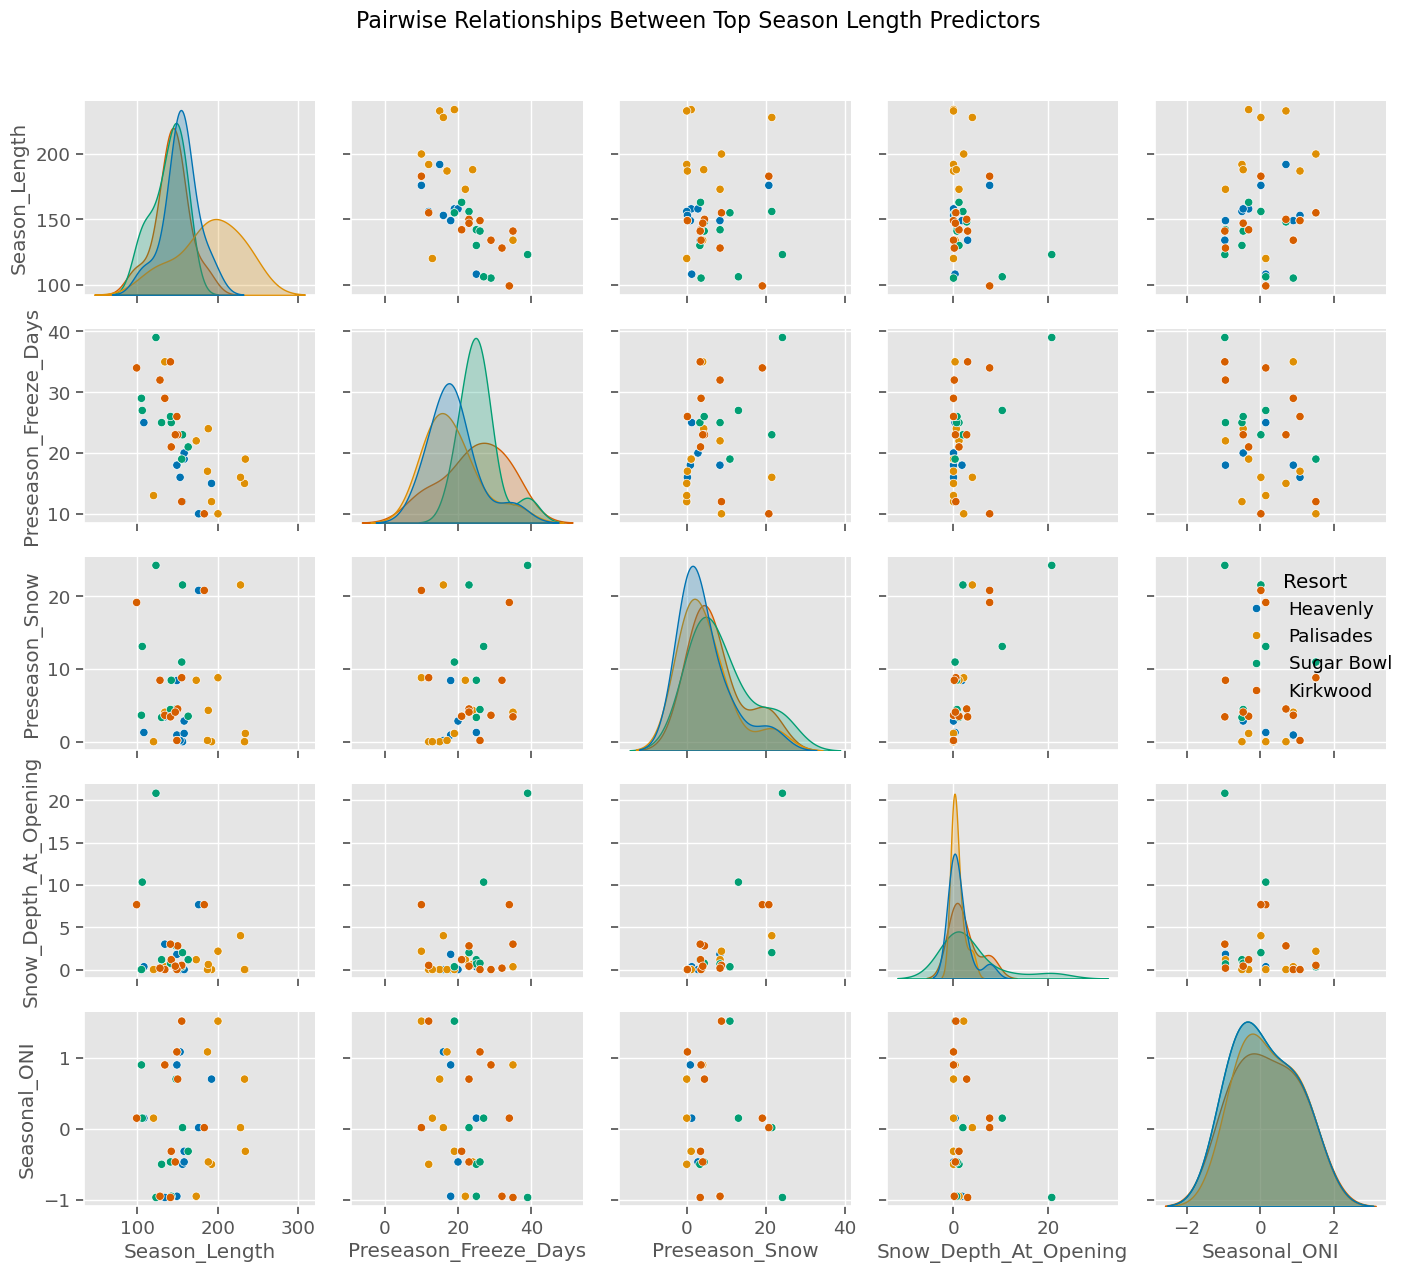

In [45]:
# Calculate correlation matrix for key metrics
correlation_cols = ['Season_Length', 'Preseason_Snow', 'Preseason_Prcp', 
                   'Preseason_Freeze_Days', 'Snow_Depth_At_Opening',
                   'Total_Season_Snow', 'Total_Season_Prcp', 
                   'Season_Freeze_Days', 'Seasonal_ONI']

correlation = seasonal_df[correlation_cols].corr()

# Create a correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(correlation, annot=True, cmap=cmap, vmin=-1, vmax=1, 
           center=0, mask=mask, square=True, linewidths=.5, fmt='.2f')

plt.title('Correlation Matrix of Key Season Metrics', fontsize=16)
plt.tight_layout()
plt.show()

# Display the strongest correlations with season length
season_length_corr = correlation['Season_Length'].drop('Season_Length').sort_values(ascending=False)
print("\nFeatures Most Correlated with Season Length:")
display(season_length_corr)

# Pairplot of the most important features
top_features = ['Season_Length', 'Preseason_Freeze_Days', 'Preseason_Snow', 
               'Snow_Depth_At_Opening', 'Seasonal_ONI']

plt.figure(figsize=(15, 12))
sns.pairplot(seasonal_df[top_features + ['Resort']], hue='Resort')
plt.suptitle('Pairwise Relationships Between Top Season Length Predictors', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

## Summary of Insights

From our exploratory analysis, we've uncovered several key relationships that help explain ski season length in the Lake Tahoe region:

### Climate Indicator Influences

1. **El Niño/La Niña Impact**: There is a notable relationship between the Oceanic Niño Index (ONI) and season length. Generally, La Niña conditions (negative ONI) are associated with longer ski seasons, while El Niño conditions (positive ONI) tend to result in shorter seasons.

2. **Resort-Specific Climate Sensitivity**: The correlation analysis shows that different resorts exhibit varying levels of sensitivity to El Niño/La Niña patterns, suggesting that local geography plays a role in how climate oscillations affect snow conditions.

### Snow and Temperature Patterns

3. **Pre-season Snow Importance**: The amount of snowfall between November 1 and opening day strongly influences both when resorts can open and ultimately how long they can operate.

4. **Freezing Days as a Key Predictor**: The number of days with temperatures below freezing, particularly in the pre-season period, shows a strong correlation with season length. This highlights the importance of consistent cold temperatures for both natural snow preservation and snowmaking opportunities.

5. **Total Seasonal Snowfall**: Not surprisingly, the total amount of snow during the season strongly correlates with season length, though pre-season conditions appear to be particularly important for setting the foundation of the season.

### Resort-Specific Findings

6. **Consistent Resort Differences**: There are clear differences in average season length between resorts, with some consistently operating longer seasons than others regardless of weather conditions. This likely reflects differences in elevation, aspect, snowmaking capacity, and operational strategies.

7. **Opening Date Patterns**: Resorts with more pre-season snow tend to open earlier, but this relationship varies by resort, suggesting differences in opening strategies and snowmaking capabilities.

These insights provide a foundation for our modeling approach in the next notebook, where we'll build a predictive model for ski season length using these identified relationships.

## Saving Intermediate Data

To facilitate our modeling work in Notebook 2, we'll save the processed datasets to their own files. This will allow us to load the prepared data directly without repeating the processing steps.

We'll save two key datasets:
1. `daily_avg.csv` - Daily aggregated weather data across all stations
2. `seasonal_df.csv` - Dataset structured at the resort-season level with all features for modeling

In [50]:
# Create a data directory if it doesn't exist
import os
data_dir = 'processed_data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print(f"Created directory: {data_dir}")

# Save the daily aggregated data
daily_avg_path = os.path.join(data_dir, 'daily_avg.csv')
daily_avg.to_csv(daily_avg_path, index=False)
print(f"Saved daily aggregated data to: {daily_avg_path}")

# Save the seasonal analysis dataset
seasonal_path = os.path.join(data_dir, 'seasonal_df.csv')
seasonal_df.to_csv(seasonal_path, index=False)
print(f"Saved seasonal analysis dataset to: {seasonal_path}")

# Optionally, save the ONI data for reference
oni_path = os.path.join(data_dir, 'oni_seasonal.csv')
oni_seasonal.to_csv(oni_path, index=False)
print(f"Saved seasonal ONI data to: {oni_path}")

print("\nAll datasets saved successfully. These files can be loaded directly in Notebook 2.")

Created directory: processed_data
Saved daily aggregated data to: processed_data/daily_avg.csv
Saved seasonal analysis dataset to: processed_data/seasonal_df.csv
Saved seasonal ONI data to: processed_data/oni_seasonal.csv

All datasets saved successfully. These files can be loaded directly in Notebook 2.
